#### Explore the ready dataset Iisights,distribution,charachtristics ...

In [6]:

from modbus import ModbusDataset
import pandas as pd 
import re   
import torch
from torch.utils.data import Dataset
import numpy as np
import json
from utils import merge_datasets
from collections import Counter
import matplotlib.pyplot as plt
import os 

In [ ]:
# # uncommit if the Labeled_CICMODBUS2023.zip not extracted yet! 
# import zipfile
# import os

# # from Labeling notebook , This file will be achieved.
# zip_path = "./Labeled_CICMODBUS2023.zip"
# extract_dir = "./dataset"

# # Create directory if missing
# os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)



In [2]:
dataset_directory = "./dataset" # change this to the folder contain benign and attack subdirs
modbus = ModbusDataset(dataset_directory,"ready",batch_size=5)
modbus.summary_print()

 The CIC Modbus Dataset contains network (pcap) captures and attack logs from a simulated substation network.
                The dataset is categorized into two groups: an attack dataset and a benign dataset
                The attack dataset includes network traffic captures that simulate various types of Modbus protocol attacks in a substation environment.
                The attacks are reconnaissance, query flooding, loading payloads, delay response, modify length parameters, false data injection, stacking Modbus frames, brute force write and baseline replay.
                These attacks are based of some techniques in the MITRE ICS ATT&CK framework.
                On the other hand, the benign dataset consists of normal network traffic captures representing legitimate Modbus communication within the substation network.
                The purpose of this dataset is to facilitate research, analysis, and development of intrusion detection systems, anomaly detection algorithms and

#### Calculate global min max of benign dataset numeric values for later min_max scaling 

In [97]:

def find_global_stats(csv_files,category = None):
    print("-"*40,category,"-"*40)
    # Group files by their subdirectory
    dir_groups = {}
    for file in csv_files:
        subdir = os.path.basename(os.path.dirname(os.path.dirname(file)))
        # Clean subdirectory name by removing '-network-capture' and '-wide-pcap-capture'
        subdir = re.sub(r'-(network|wide)-(pcap-)?capture(s?)', '', subdir)
        if subdir not in dir_groups:
            dir_groups[subdir] = []
        dir_groups[subdir].append(file)
    
    all_global_stats = {}
    all_label_counts = {}
    for subdir, files in dir_groups.items():
        # Read first file to get numeric columns
        first_df = pd.read_csv(files[0], encoding='cp1252')
        numeric_cols = first_df.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], errors='ignore').select_dtypes(include=['number']).columns.tolist()
        
        # Initialize trackers for statistics
        stats = {
            col: {
                'count': 0, 
                'sum': 0.0, 
                'sum_sq': 0.0, 
                'min': float('inf'), 
                'max': float('-inf'),
                'duplicates': 0,
            } for col in numeric_cols
        }
        
        # Initialize counter for Label column
        label_counts = Counter()
        # To track unique values for duplicates calculation
        unique_values = {col: set() for col in numeric_cols}
        len_csv_files = len(files)

        for file_index,file in enumerate(files):
            # Read only necessary columns (numeric_cols + Label)
            print("node : ",subdir,", file_",file_index+1,"/",len_csv_files,":",file)

            df = pd.read_csv(file, encoding='cp1252', usecols=numeric_cols + ['Label'], low_memory=False)
            
            # Count labels in the current file
            if 'Label' in df.columns:
                label_counts.update(df['Label'])
            
            for col in numeric_cols:
                # Track unique values for duplicates
                current_values = set(df[col])
                stats[col]['duplicates'] += len(df[col]) - len(current_values - unique_values[col])
                unique_values[col].update(current_values)
                
                # Update other statistics (only for non-NaN values)
                valid_data = df[col]
                stats[col]['count'] += len(valid_data)
                stats[col]['sum'] += valid_data.sum()
                stats[col]['sum_sq'] += (valid_data ** 2).sum()
                stats[col]['min'] = min(stats[col]['min'], valid_data.min()) if not valid_data.empty else stats[col]['min']
                stats[col]['max'] = max(stats[col]['max'], valid_data.max()) if not valid_data.empty else stats[col]['max']
        
        # Compute final statistics for numeric columns
        feature = {}
        for col in numeric_cols:
            count = stats[col]['count']
            mean = stats[col]['sum'] / count if count > 0 else np.nan
            variance = (stats[col]['sum_sq'] / count - mean ** 2) if count > 0 else np.nan
            std = np.sqrt(variance) if variance >= 0 else np.nan
            feature[col] = {
                'count':count,
                'mean': mean,
                'std': std,
                'min': stats[col]['min'],
                'max': stats[col]['max'],
                'duplicates': stats[col]['duplicates']
            }

        
        # Store results for this subdirectory
        all_global_stats[subdir] = feature
        all_label_counts[subdir] = dict(label_counts)
    
    return all_global_stats, all_label_counts

def print_statistics(_global_stats):

    for index, _global_stat in enumerate(_global_stats):
        global_stats_df = pd.DataFrame(_global_stats[_global_stat]).transpose()
        print("-"*80,"\nnode_", index," :",_global_stat,"\nflows count_",global_stats_df['count'].iloc[0])

        # Display with all rows and columns visible
        with pd.option_context('display.max_rows', None, 
                            'display.max_columns', None, 
                            'display.width', None,
                            'display.float_format', '{:.2f}'.format):  # Adjust decimal places as needed
            print(global_stats_df.drop(columns=['count']))
def plot_label_counts_subplots(all_label_counts):
    n_subdirs = len(all_label_counts)
    ncols = 2  
    nrows = (n_subdirs + 1) // 2  
    
    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), squeeze=False)
    axes = axes.flatten() 
    
    # Plot each subdirectory's label counts
    for idx, (subdir, label_counts) in enumerate(all_label_counts.items()):
        labels = list(label_counts.keys())
        counts = list(label_counts.values())
        
        bars = axes[idx].bar(labels, counts, color=['#36A2EB', '#FF6384', '#FFCE56', '#4BC0C0', '#9966FF'][:len(labels)])
        axes[idx].set_title(f'Label Distribution: {subdir}')
        axes[idx].set_xlabel('Labels')
        axes[idx].set_ylabel('Count')
        # Increase rotation and adjust font size to reduce overlap
        axes[idx].tick_params(axis='x', rotation=60, labelsize=8)
        
        # Add count numbers on top of each bar
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(
                bar.get_x() + bar.get_width() / 2,  
                height,  #
                f'{int(height)}',  
                ha='center',  
                va='bottom', 
                fontsize=9
            )
    axes[idx].set_ylim(0, max(counts) * 1.15)
    # Hide any unused subplots
    for idx in range(len(all_label_counts), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

#### statistics and label distribution between the ICS nodes

In [91]:
attack_global_stats, attack_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["total"],"attack")
ext_global_stats, ext_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["external"],"external")
com_ied_global_stats, com_ied_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-ied"],"compromised-ied")
com_scd_global_stats, com_scd_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-scada"],"compromised-scada")
benign_global_stats, benign_label_counts = find_global_stats(modbus.dataset["benign_dataset_dir"],"benign")


---------------------------------------- attack ----------------------------------------
node :  network-wide , file_ 1 / 2 : ./dataset/ModbusDataset/attack/external/network-wide/ready/network-wide-normal-1-labeled.csv
node :  network-wide , file_ 2 / 2 : ./dataset/ModbusDataset/attack/external/network-wide/ready/network-wide-normal-0-labeled.csv
node :  ied4c , file_ 1 / 13 : ./dataset/ModbusDataset/attack/external/ied4c/ied4c-network-capture/ready/veth8bc3408-0-labeled.csv
node :  ied4c , file_ 2 / 13 : ./dataset/ModbusDataset/attack/compromised-scada/ied4c/ied4c-network-captures/ready/vethe685ac9-0-labeled.csv
node :  ied4c , file_ 3 / 13 : ./dataset/ModbusDataset/attack/compromised-scada/ied4c/ied4c-network-captures/ready/vethe685ac9-5-labeled.csv
node :  ied4c , file_ 4 / 13 : ./dataset/ModbusDataset/attack/compromised-scada/ied4c/ied4c-network-captures/ready/vethe685ac9-1-labeled.csv
node :  ied4c , file_ 5 / 13 : ./dataset/ModbusDataset/attack/compromised-scada/ied4c/ied4c-netwo

##### benign 

-------------------------------------------------------------------------------- 
node_ 0  : network-wide 
flows count_ 2822444.0
                                  mean         std   min            max  \
Protocol                          6.00        0.16  2.00          17.00   
Flow Duration              10297843.17         NaN  0.00   119999783.00   
Total Fwd Packet                  4.27        2.50  0.00         226.00   
Total Bwd packets                 3.30        1.65  0.00         210.00   
Total Length of Fwd Packet       17.41      189.83  0.00       52116.00   
Total Length of Bwd Packet        7.97       14.79  0.00        3914.00   
Fwd Packet Length Max             9.21       14.84  0.00         700.00   
Fwd Packet Length Min             0.01        1.08  0.00         118.00   
Fwd Packet Length Mean            1.92        7.00  0.00         230.60   
Fwd Packet Length Std             3.97        7.45  0.00         350.00   
Bwd Packet Length Max             7.35       

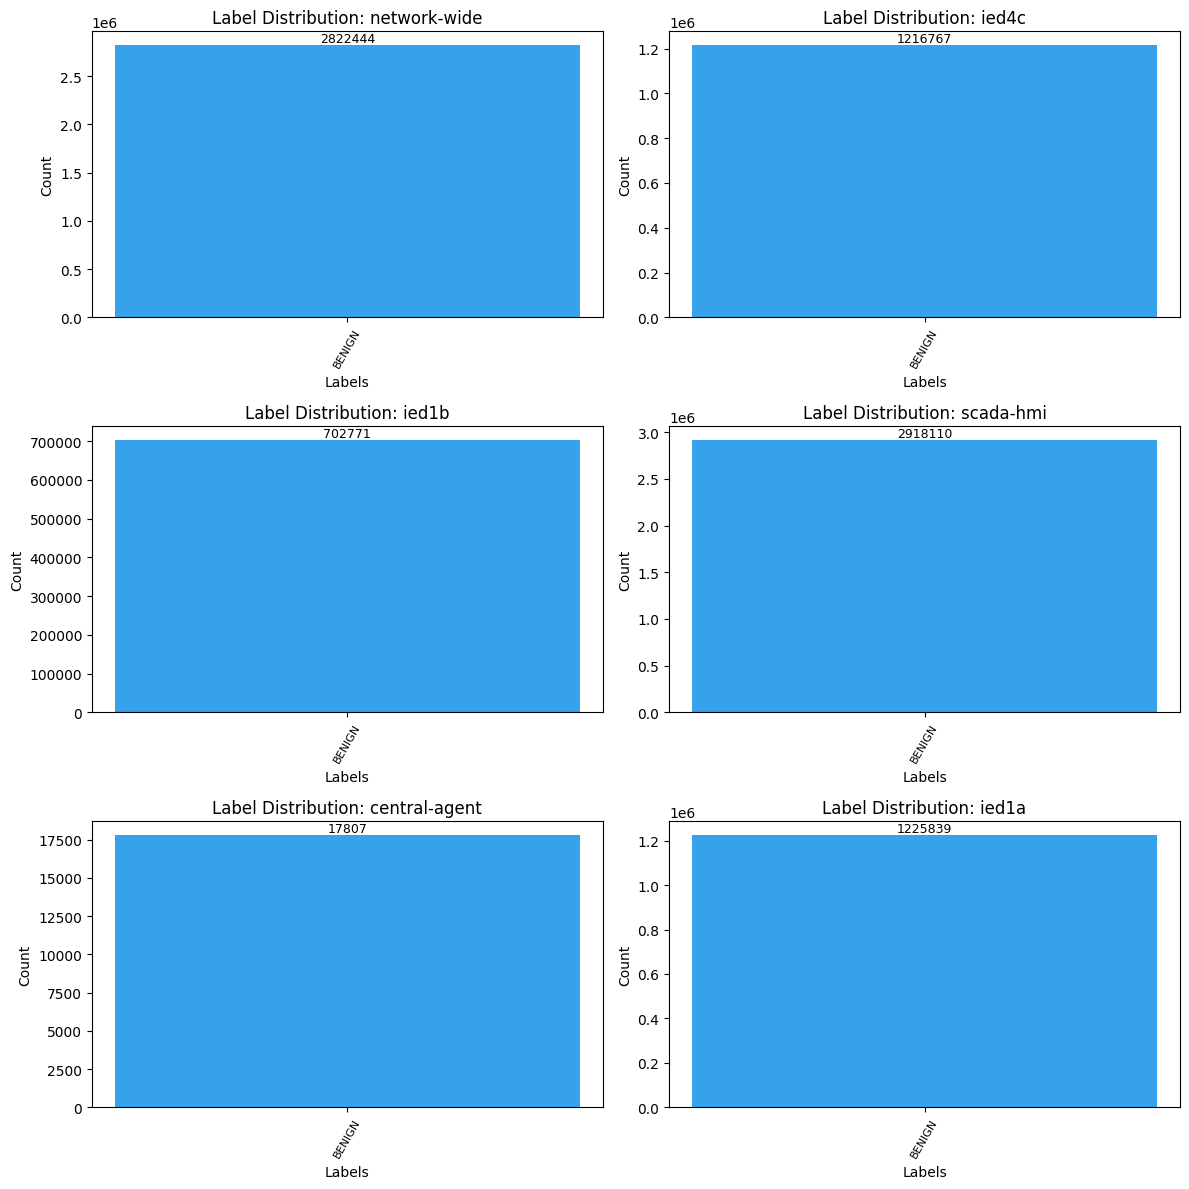

In [95]:

print_statistics(benign_global_stats)
plot_label_counts_subplots(benign_label_counts)


##### total attacks

-------------------------------------------------------------------------------- 
node_ 0  : network-wide 
flows count_ 221329.0
                                  mean         std   min            max  \
Protocol                          6.00        0.13  2.00          17.00   
Flow Duration               7108321.29         NaN  0.00   119612092.00   
Total Fwd Packet                  4.26        2.12  0.00         244.00   
Total Bwd packets                 3.46        1.42  0.00         126.00   
Total Length of Fwd Packet       15.06      148.64  0.00       31874.00   
Total Length of Bwd Packet        5.53       12.18  0.00        2394.00   
Fwd Packet Length Max             9.95       12.26  0.00         276.00   
Fwd Packet Length Min             0.01        0.89  0.00         118.00   
Fwd Packet Length Mean            2.20        5.83  0.00         131.83   
Fwd Packet Length Std             4.51        6.23  0.00         146.07   
Bwd Packet Length Max             5.15        

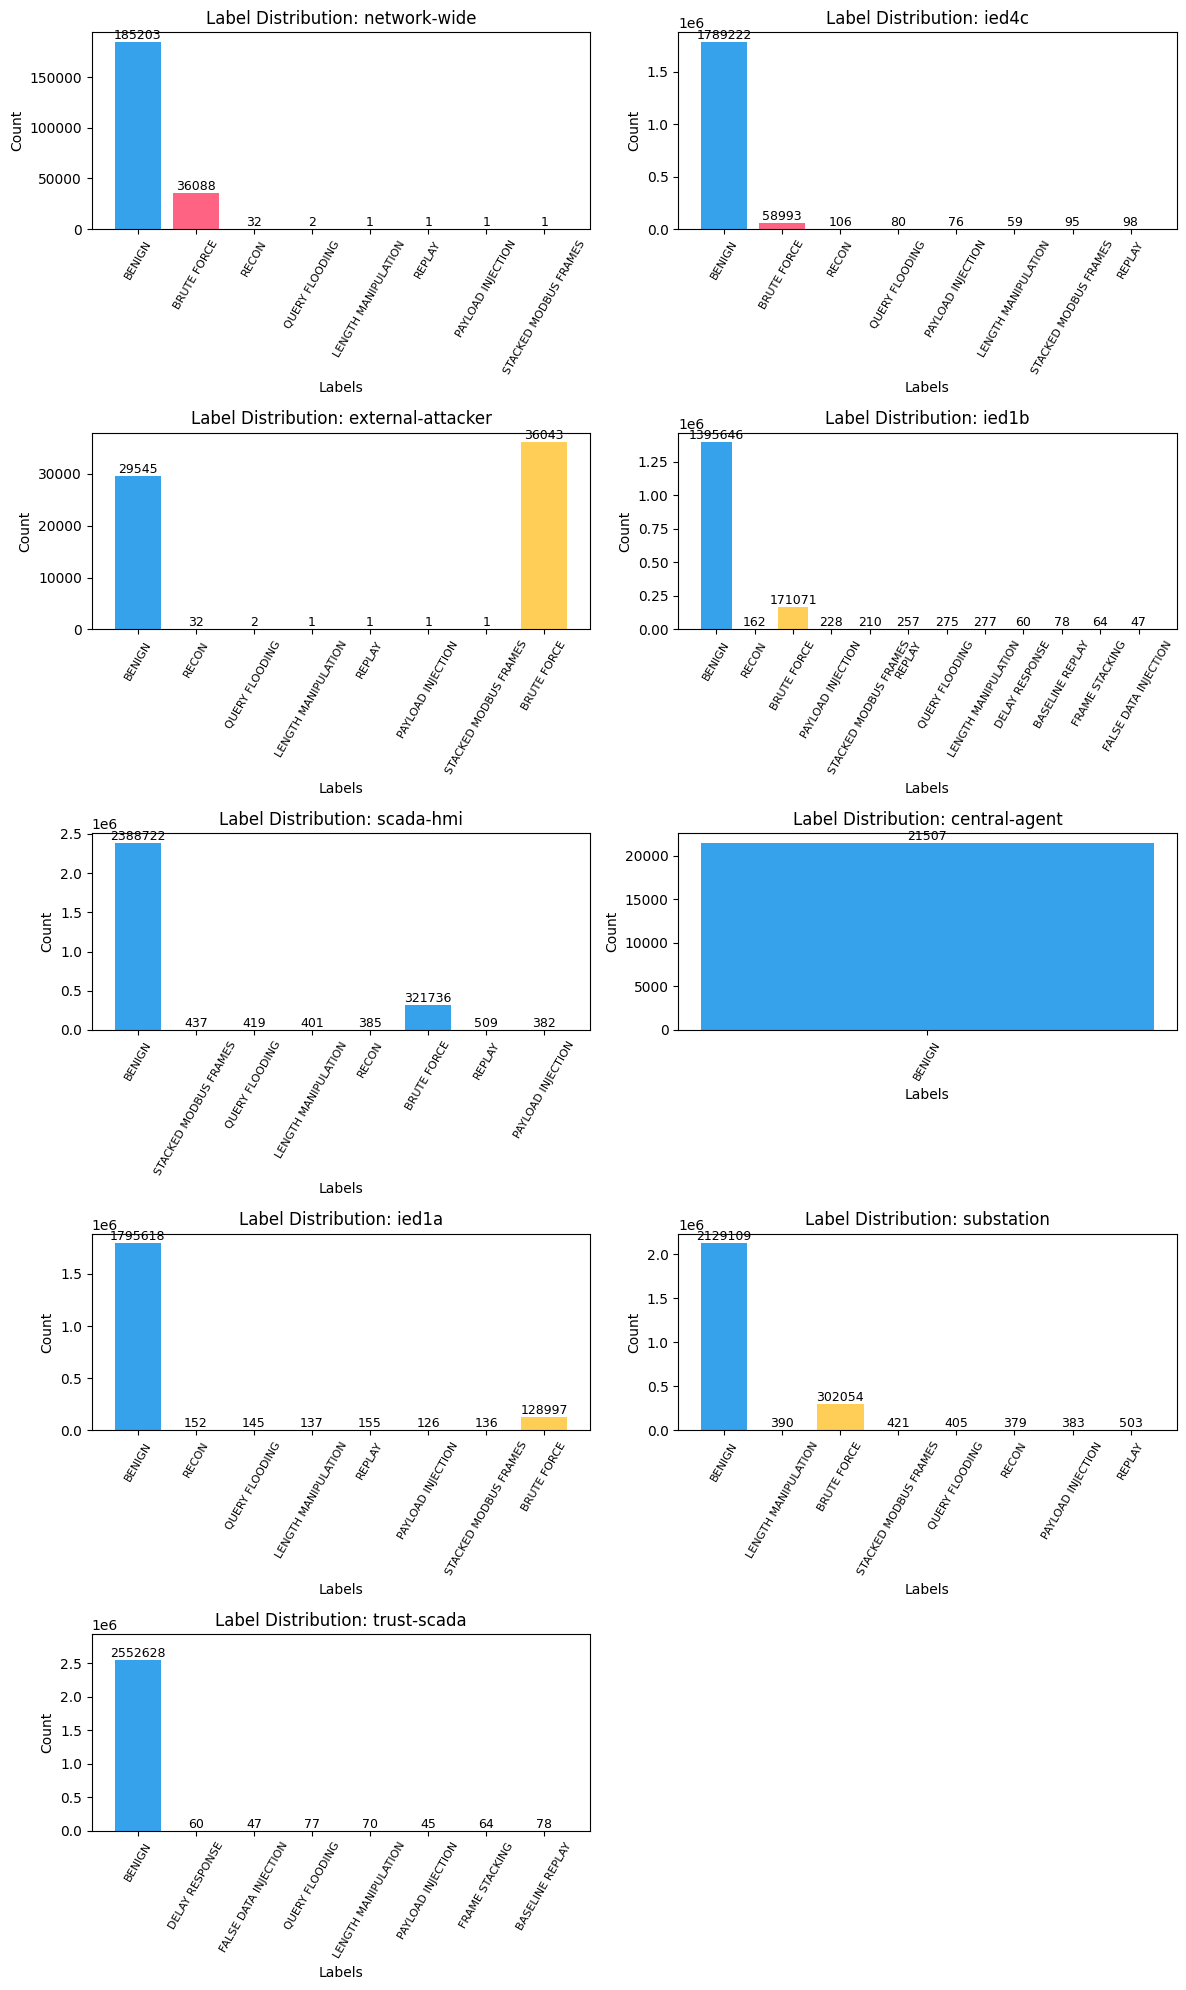

In [98]:

print_statistics(attack_global_stats)
plot_label_counts_subplots(attack_label_counts)


-------------------------------------------------------------------------------- 
node_ 0  : network-wide 
flows count_ 221329.0
                                  mean         std   min            max  \
Protocol                          6.00        0.13  2.00          17.00   
Flow Duration               7108321.29         NaN  0.00   119612092.00   
Total Fwd Packet                  4.26        2.12  0.00         244.00   
Total Bwd packets                 3.46        1.42  0.00         126.00   
Total Length of Fwd Packet       15.06      148.64  0.00       31874.00   
Total Length of Bwd Packet        5.53       12.18  0.00        2394.00   
Fwd Packet Length Max             9.95       12.26  0.00         276.00   
Fwd Packet Length Min             0.01        0.89  0.00         118.00   
Fwd Packet Length Mean            2.20        5.83  0.00         131.83   
Fwd Packet Length Std             4.51        6.23  0.00         146.07   
Bwd Packet Length Max             5.15        

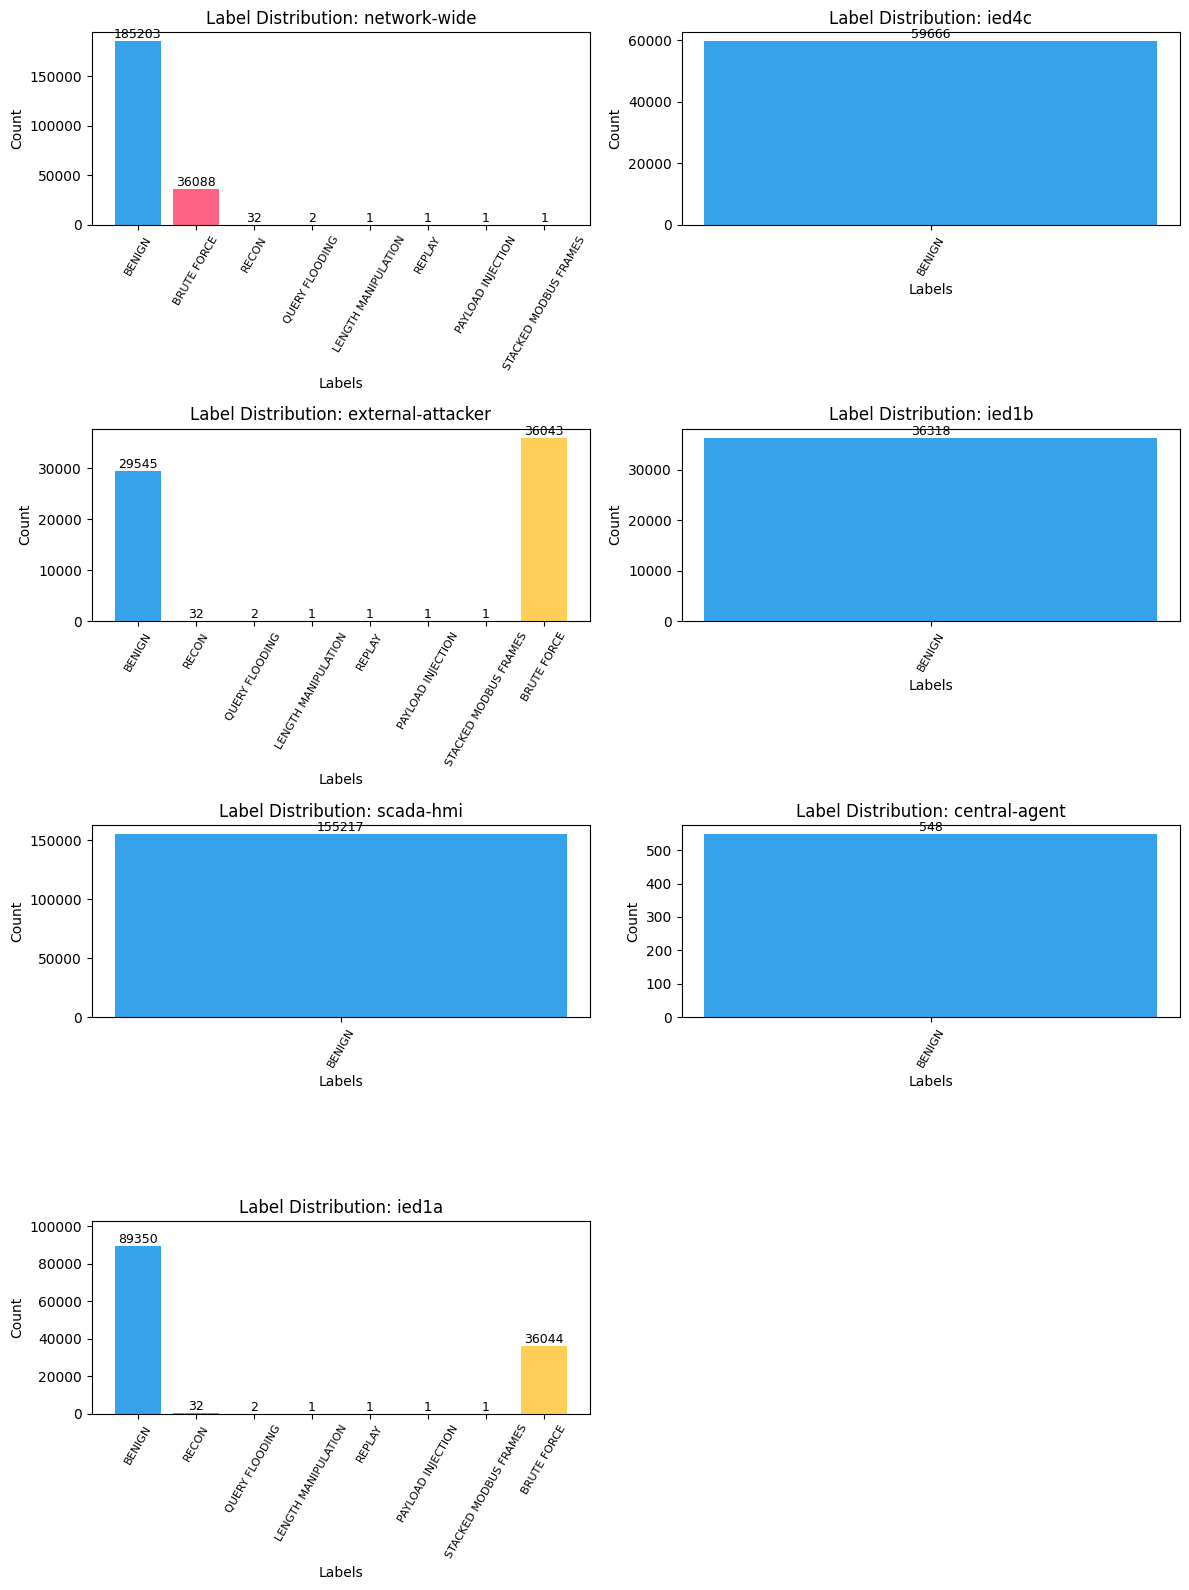

In [99]:

print_statistics(ext_global_stats)
plot_label_counts_subplots(ext_label_counts)


In [21]:
def convert_list_of_dataframes_to_numpy(list_of_dfs):
    numpy_arrays = [df.to_numpy() for df in list_of_dfs]
    combined_array = np.concatenate(numpy_arrays, axis=0)
    return combined_array

# Example usage
df1 = pd.DataFrame({'A': [1, 2], 'B': [3, 4]})
df2 = pd.DataFrame({'A': [5, 6,7], 'B': [7, 8,9] })

list_of_dfs = [df1, df2]
result = convert_list_of_dataframes_to_numpy(list_of_dfs)

print(result)

[[1 3]
 [2 4]
 [5 7]
 [6 8]
 [7 9]]


(68931, 87)
(68931, 87) (68931,)
(152398, 87) (152398,)
(59666, 87) (59666,)
(65626, 87) (65626,)
(36318, 87) (36318,)
(382939, 87)
